<a href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/notebooks/Lab-10.KernelPCA_KernelSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA

from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh


Kernel regression
===============

https://knork.medium.com/linear-regression-in-python-from-scratch-with-kernels-e9c37f7975b9

**Recap**: the solution of the linear regression $y=wX$ can be also written as:

$$
w=(X^{T}X)^{-1}X^{T}y=X^{T}(XX^{T})^{-1}y
$$


Let $X\in R^{N\times d}$, then $X^{T}X\in R^{d\times d}$ and $K=XX^{T}\in R^{N\times N}$: it all depends on the ratio $\frac{d}{N}$ which matrix is more convenient (i.e. less computational demanding) to compute. 

For predictions, we plug the above for a test point $z$ and get:

$$
f(z)=z^{T}w=z^{T} X^{T}(XX^{T})^{-1}y= \alpha^{T}(z)K^{-1}y
$$

with $\alpha(z)=z^{T}X^{T}=K(z,X)\in R^{1\times N}$.

This is the case for linear regression. How can we extend to the non-linear case?  $x\rightarrow \phi(x)$, and the reasoning above repeats.


Also: https://github.com/luigicarratino/Tutorial_Kernels_MLSS2019_London/blob/master/Tutorial%20Kernel.ipynb



## Recap on different kernel functions 

See also: https://www.cs.toronto.edu/~duvenaud/cookbook/

1. **Linear Kernel**: $k(x, y) = <x, y> = x\cdot y$ fast to compute, hence convenient when there are a lot of features and no need to map points in a higher dimensional space. Usually combined with other kernels to increase their expressiveness. 

2. **Polynomial Kernel**: $k(x, y)= (1 + x\cdot y)^p$ ($p$ is the degree) non-linear function if $p>1$, it allows to cnsider interactions among features up to order $p$.

3. **Radial Basis Funtion / Gaussian Kernel**: $k(x, y) = \bigg( -\frac{||x - y||_2}{2 \sigma^2} \bigg)$ it is arguably the most used, as it can map points potentially to infinite dimenional space (think about Taylor expansion) hence it is potentially able to fit any dataset. 

In [3]:
def kernelFunc(x1, x2, kernel_type, param):
    if kernel_type == 'poly':
        return (1 + np.dot(x1, x2)) ** param
    elif kernel_type == 'rbf':
        return np.exp(- np.dot(x1-x2,x1-x2) / (2 * param))
    elif kernel_type == 'linear':
        return np.dot(x1,x2)

RBF Kernel PCA
=============

***PCA recap***

Normalization
$$
x\rightarrow x-\frac{1}{d}\sum_{j}(x)_{j}\
$$

Eigenvectors of the covariance matrix are the new coordinates (thanks to normalization):
$$
Cv=\lambda v\;\;\;\;\;\;\;C=\frac{1}{N}\sum_{i}x_{i}x^{T}_{i}
$$

The first $d$ eigenvalues provide information about the amount of information (i.e. variance) retained if we use only the first $d$ eigendirection.

<img src="http://www.nlpca.org/fig_pca_principal_component_analysis.png" alt= “” width="600" height="300">





However it may not be applicable to data at hand:

<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/10/pca_example_1.png" alt= “” width="800" height="400">



***Kernel PCA***

**Intuition**: use a kernel function to map features in a different (often higher dimensional) feature space, then perform dimensionality reduction in this new space using PCA.

New Features
$$
x\rightarrow \phi(x)
$$

Covariance eigenvalues and eigenvectors:

$$
C_{K}v=\lambda v\;\;\;\;\;\;\;\;C_{K}=\frac{1}{N}\sum_{i}\phi(x_{i})\phi^{T}(x_{i})
$$

One can prove that eigenvectors are linear combinations of features: 

$$
v=\sum_{i}\alpha_{i}\phi(x_{i})\;\;\; \alpha_i = \frac{\phi(x_i)^T v}{N\lambda}
$$

This comes from the fact that K should be a *Gram Matrix*, which is symmetric positive definite and we search for
a low rank approximation of the Kernel. The Kernel for how it is computed is not readily a good Gram Matrix, it should undergo a process called
*Double Centering* (this is only a requirement to center the matrix around 0, requiring only a linear transformation on elements). The math behind
is quite verbose, if you want more info ask me.

Multiplying both sides of $C_{K}v=\lambda v$ by $\phi(x_{k})$ we have the following eigendecomposition:

$$
N\lambda \alpha = K \alpha
$$

Normalization
$$
\phi(x)\rightarrow \phi(x)-\frac{1}{d}\sum_{i}(\phi(x))_{i} 
$$

The resulting kernel is

$$
K\rightarrow K - \dfrac{1}{N}\mathbb{1}K - \dfrac{1}{N}K\mathbb{1} + \dfrac{1}{N}\mathbb{1}K\mathbb{1}
$$

with $\mathbb{1}$ being the matrix of all ones


See also  https://sdat.ir/en/sdat-blog/python-kernel-tricks-and-nonlinear-dimensionality-reduction-via-rbf-kernel-pca


Performing PCA in a higher dimension might be more suitable:

<img src="https://2.bp.blogspot.com/_slrAR0IXTL0/TF-OZaNbRCI/AAAAAAAAAUo/SdYS3hXd4MI/s1600/figure.png" alt= “” width="600" height="600">

Hence, given a $M\times M$ kernel matrix $K$ for a dataset of $M$ points, to get its principal components we should compute the following:

1. Center the kernel matrix by computing $K\rightarrow K-2Id_{1/n}K + Id_{1/n}K Id_{1/n}$
3. Find ordered eigenvalues and eigenvectors of $K$ 

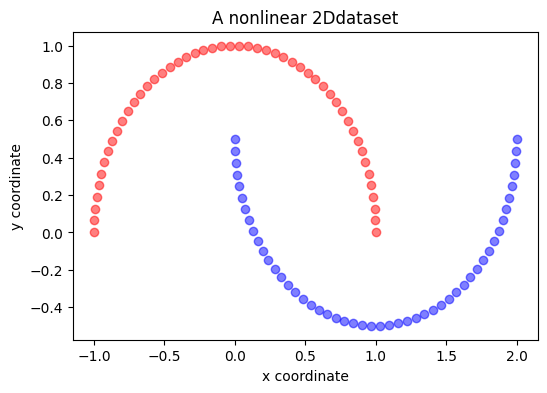

In [3]:
# very famous example of non-linearly-separable dataset
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)

plt.figure(figsize=(6,4))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

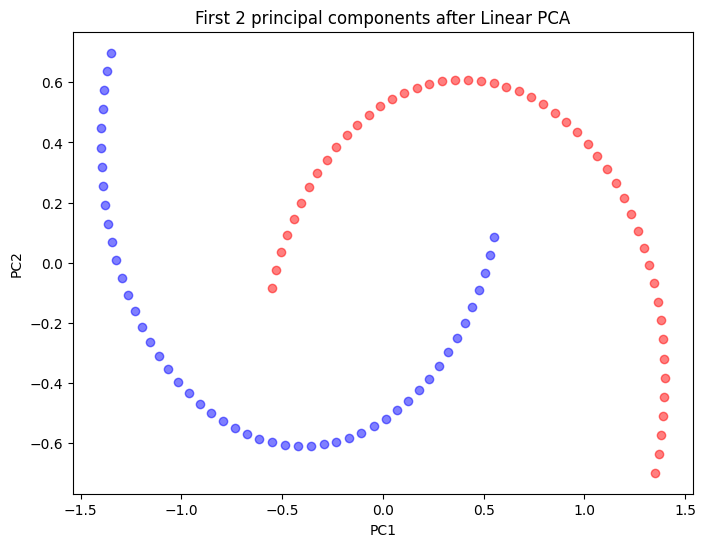

In [4]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

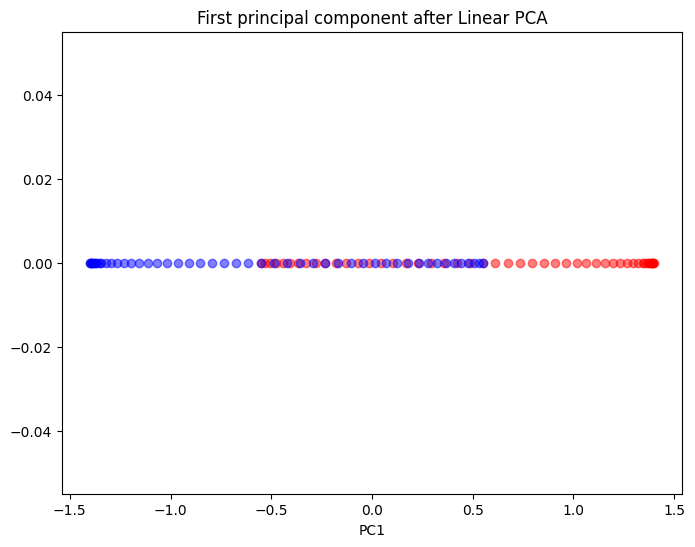

In [5]:
scikit_pca = PCA(n_components=1)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], np.zeros((50,1)), color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], np.zeros((50,1)), color='blue', alpha=0.5)

plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')

plt.show()

In [ ]:
kernel_type = 'gaussian'
param = 2

# implement KPCA with our defined RBF kernel and fit to moon dataset

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(rbf_kpca[y==0, 0], rbf_kpca[y==0, 1], color='red', alpha=0.5)
plt.scatter(rbf_kpca[y==1, 0], rbf_kpca[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after RBF Kernel PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Kernel SVM 

**Recall**: Suppport Vector Machines (SVM) separates data by finding an hyperplane which maximizes the margin between classes.

Kernel SVM use kernels to map data in a higher dimensional feature space, where the maximal margin hyperplane is learned. 

In [ ]:
# from svm lab
def hingeFunction(z):
    return np.maximum(1-z,0)


def hingesubgrad(z):
    g = np.zeros(z.shape)
    g[z < 1] = -1
    return g

def ReghingeLoss(X,labels,w, lam):
    d = np.shape(X)[0]
    L = np.mean(np.maximum(np.ones(d) - labels*(X@w), 0)) + lam * LA.norm(w,2) 
    return L

def svmGrad(X, labels, w, lam):
    g1 = hingesubgrad(np.diag(labels)@(X@w))
    g2 = np.diag(labels)@X
    return g1.dot(g2) + 2*lam*w

def svm_training(X, labels, lam, Iter, gamma):
    # get dimensions
    d = np.shape(X)[1]
    # initialise weight vector and set first column to a random vector
    W = np.zeros((d,Iter))
    W[:,0] = np.random.normal(0,0.01,d)
    # initialise loss vector
    L = np.zeros(Iter)

    for i in range(Iter-1):
        # update weights using subgradient descent algorithm
        W[:,i+1] = W[:,i] - gamma * svmGrad(X, labels, W[:,i], lam)

        # save loss
        L[i] = ReghingeLoss(X,labels,W[:,i],lam)

    return W, L

In [9]:
# get SVM's predictions
def predlabels(X, w): 
    y = np.sign(X@w)
    return y

# calculate accuracy
def acc(labels, predlabels):
     return np.count_nonzero(labels == predlabels)/len(labels)   

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

kernel_type = 'Gaussian'
param = 15

# implement and test kernel SVM with our defined kernel and SVM 


In [ ]:
plt.figure(figsize=(6,4))

plt.scatter(X_test[y_pred==0, 0], X_test[y_pred==0, 1], color='red', alpha=0.5)
plt.scatter(X_test[y_pred==1, 0], X_test[y_pred==1, 1], color='blue', alpha=0.5)

plt.title('Kernel SVM Binary Classification')

plt.show()

**Sklearn Kernel SVM Function**

In [10]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', gamma=15)
svc.fit(X_train, y_train)
y_pred_sk = svc.predict(X_test)
print('Accuracy with sklearn: ', acc(y_test, y_pred_sk))

Accuracy with sklearn:  1.0


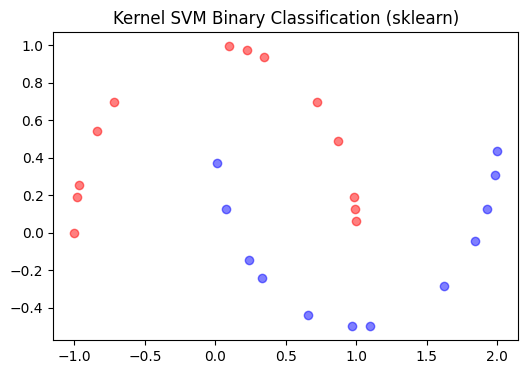

In [11]:
plt.figure(figsize=(6,4))

plt.scatter(X_test[y_pred_sk==0, 0], X_test[y_pred_sk==0, 1], color='red', alpha=0.5)
plt.scatter(X_test[y_pred_sk==1, 0], X_test[y_pred_sk==1, 1], color='blue', alpha=0.5)

plt.title('Kernel SVM Binary Classification (sklearn)')

plt.show()

## A more real life example
### The beloved MNIST dataset

The MNIST dataset (Modified National Institute of Standards and Technology) is a collection of 70,000 grayscale images of handwritten digits (0-9), each of size 28x28 pixels. It is widely used in machine learning and deep learning for image classification tasks. MNIST serves as a benchmark dataset for evaluating algorithms.

Let's see how our kernel methods work on the mnist dataset.
We will use sklearn methods.

Suggestion, choose a subset $\sim$ 10000 of those images, since otherwise you will need 200Gb of RAM :)

Tasks:

- Load MNIST dataset
- Apply classical PCA, plot the first two principal components, then visualize the eigenvectors
- Apply kernel PCA, plot the first two principal components (colour by class datapoints)
- Choose two classes (eg. 5 and 8) and build an SVM that can distinguish between them



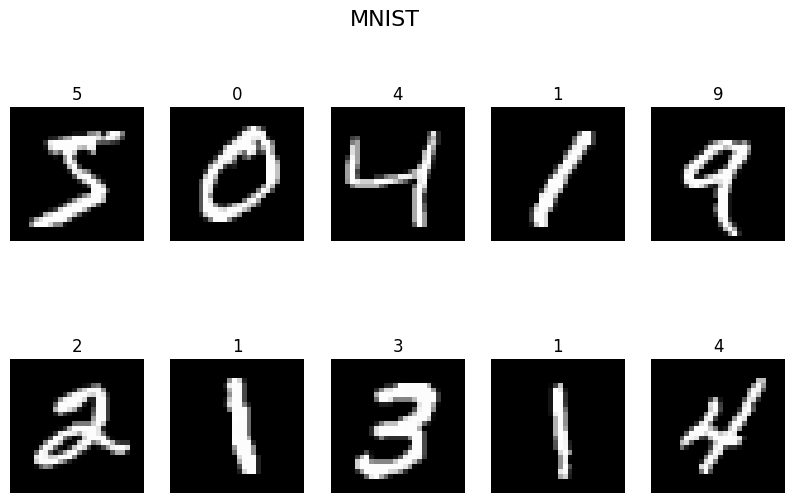

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)


# Plot some sample images
fig, axes = plt.subplots(2, 5, figsize=(10, 6))
fig.suptitle("MNIST", fontsize=16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(28,28), cmap='gray')
    ax.set_title(f"{y[i]}")
    ax.axis("off")

plt.show()